In [1]:
import numpy as np 
import pandas as pd 
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns
import sys
import copy
import math
from scipy.stats import chi2


import warnings
from pandas.core.common import SettingWithCopyWarning

import Regression

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import dcor 
from scipy.stats import pearsonr
np.seterr(divide = 'ignore') 

from lifelines import CoxPHFitter
from scipy.stats import norm


In [ ]:
from scipy.stats import chi2

# Set some options for printing all the columns
np.set_printoptions(precision = 10, threshold = sys.maxsize)
np.set_printoptions(linewidth = np.inf)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
pd.options.display.float_format = '{:,.7f}'.format

In [2]:
claim_history = pd.read_excel("claim_history.xlsx")

In [3]:
claim_history.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,TIF,CAR_TYPE,RED_CAR,REVOKED,MVR_PTS,CAR_AGE,URBANICITY,CLM_AMT,CLM_COUNT,EXPOSURE
0,63581743,0,1939-03-16,60.0,0,11.0,67000.0,No,NaN,No,...,11,Minivan,yes,No,3,18.0,Highly Urban/ Urban,0,0,0.189
1,132761049,0,1956-01-21,43.0,0,11.0,91000.0,No,257000.0,No,...,1,Minivan,yes,No,0,1.0,Highly Urban/ Urban,0,0,1.000
2,921317019,0,1951-11-18,48.0,0,11.0,53000.0,No,NaN,No,...,1,Van,yes,No,2,10.0,Highly Urban/ Urban,0,0,1.000
3,727598473,0,1964-03-05,35.0,1,10.0,16000.0,No,124000.0,Yes,...,4,SUV,no,No,3,10.0,Highly Urban/ Urban,0,0,0.828
4,450221861,0,1948-06-05,51.0,0,14.0,NaN,No,306000.0,Yes,...,7,Minivan,yes,No,0,6.0,Highly Urban/ Urban,0,0,0.729


In [4]:
yName = 'CLM_AMT'
eName = 'EXPOSURE'
intName = ['AGE', 'BLUEBOOK', 'CAR_AGE', 'HOME_VAL', 'HOMEKIDS', 'INCOME', 'YOJ', 'KIDSDRIV', 'MVR_PTS', 'TIF', 'TRAVTIME']
catName = ['CAR_TYPE', 'CAR_USE', 'EDUCATION', 'GENDER', 'MSTATUS', 'PARENT1', 'RED_CAR', 'REVOKED', 'URBANICITY']

train_data = claim_history[[yName, eName] + catName + intName]
train_data = train_data[train_data[eName] > 0.0].dropna().reset_index(drop = True)
y_train = train_data[yName]
o_train = np.log(train_data[eName])
train_data.shape

(5715, 22)

### Question 1

a) (10 points). We will first estimate the Tweedie distribution’s Power parameter 𝑝 and Scale
parameter 𝜙. To this end, we will calculate the sample means and the sample variances of the claim
amount for each value combination of the categorical predictors. Then, we will train a linear
regression model to help us estimate the two parameters. What are their values? Please provide us
with your appropriate chart

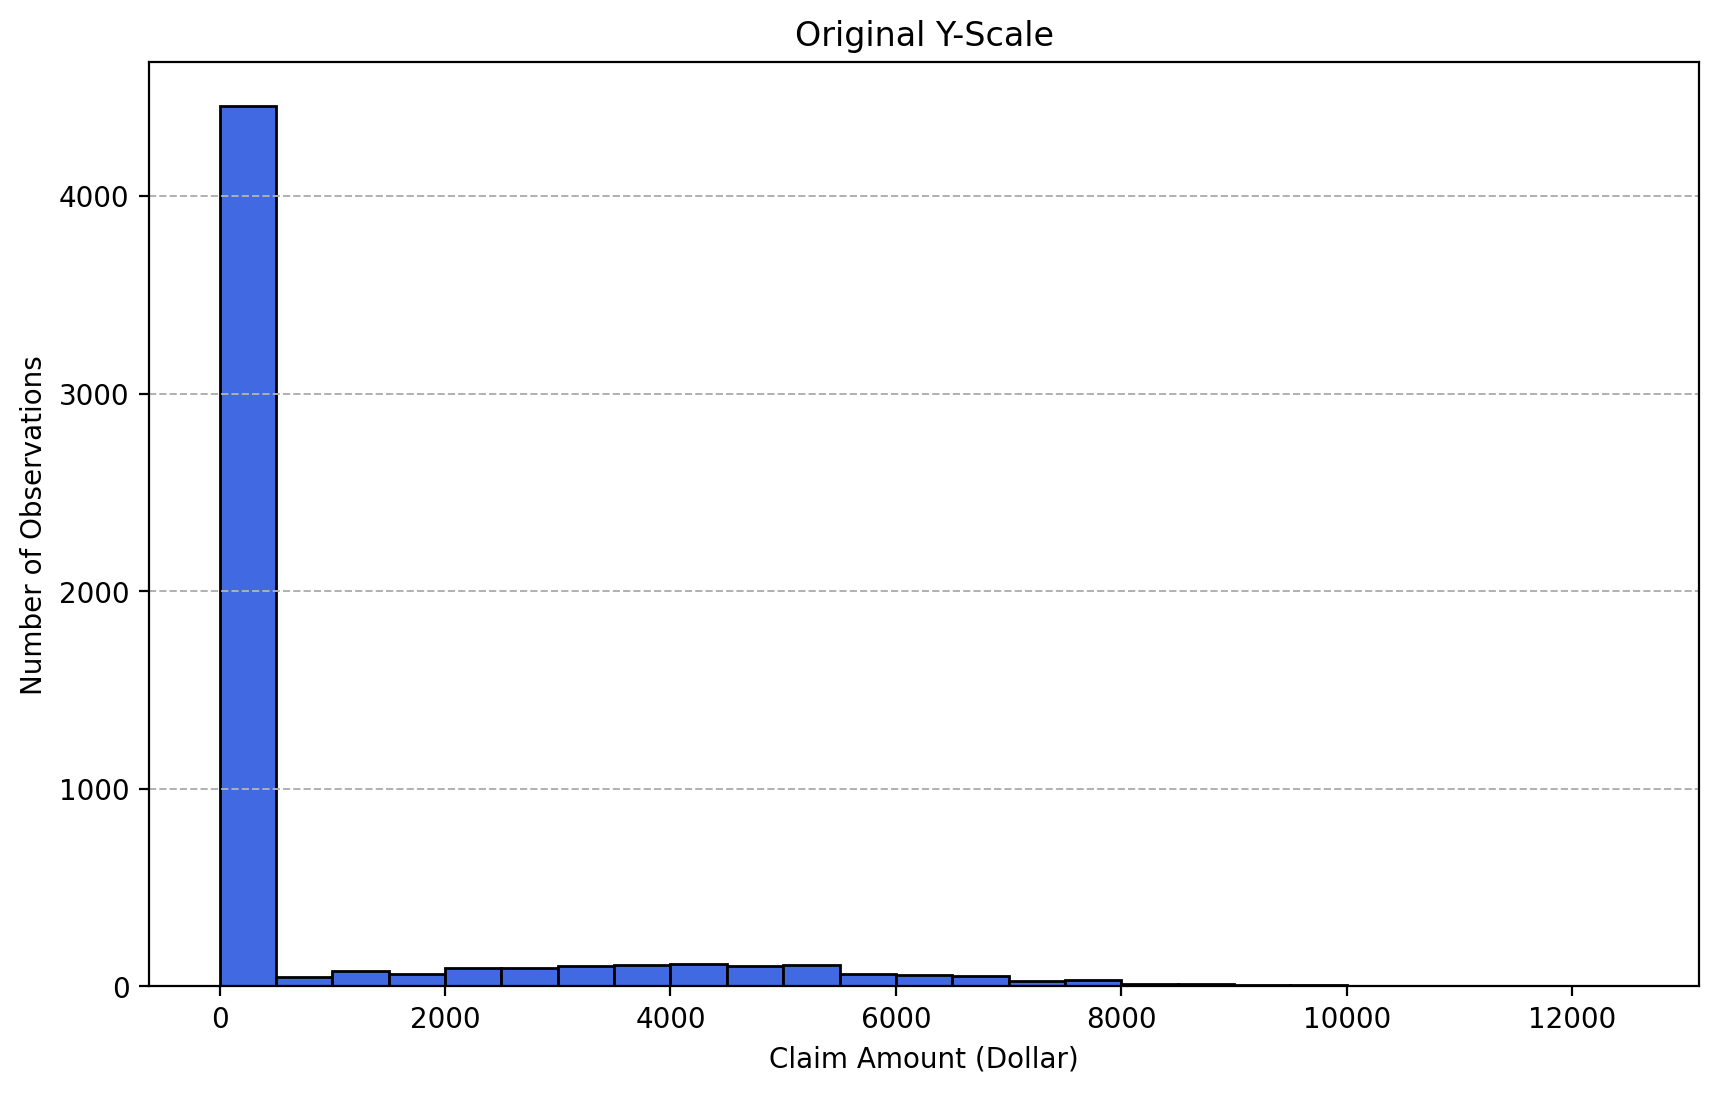

In [5]:

# Histogram of Claim Amount
plt.figure(figsize = (10,6), dpi = 200)
plt.hist(y_train, bins = np.arange(0,13000,500), fill = True, color = 
'royalblue', edgecolor = 'black')
plt.title('Original Y-Scale')
plt.xlabel('Claim Amount (Dollar)')
plt.ylabel('Number of Observations')
plt.xticks(np.arange(0,14000,2000))
plt.grid(axis = 'y', linewidth = 0.7, linestyle = 'dashed')
plt.show()


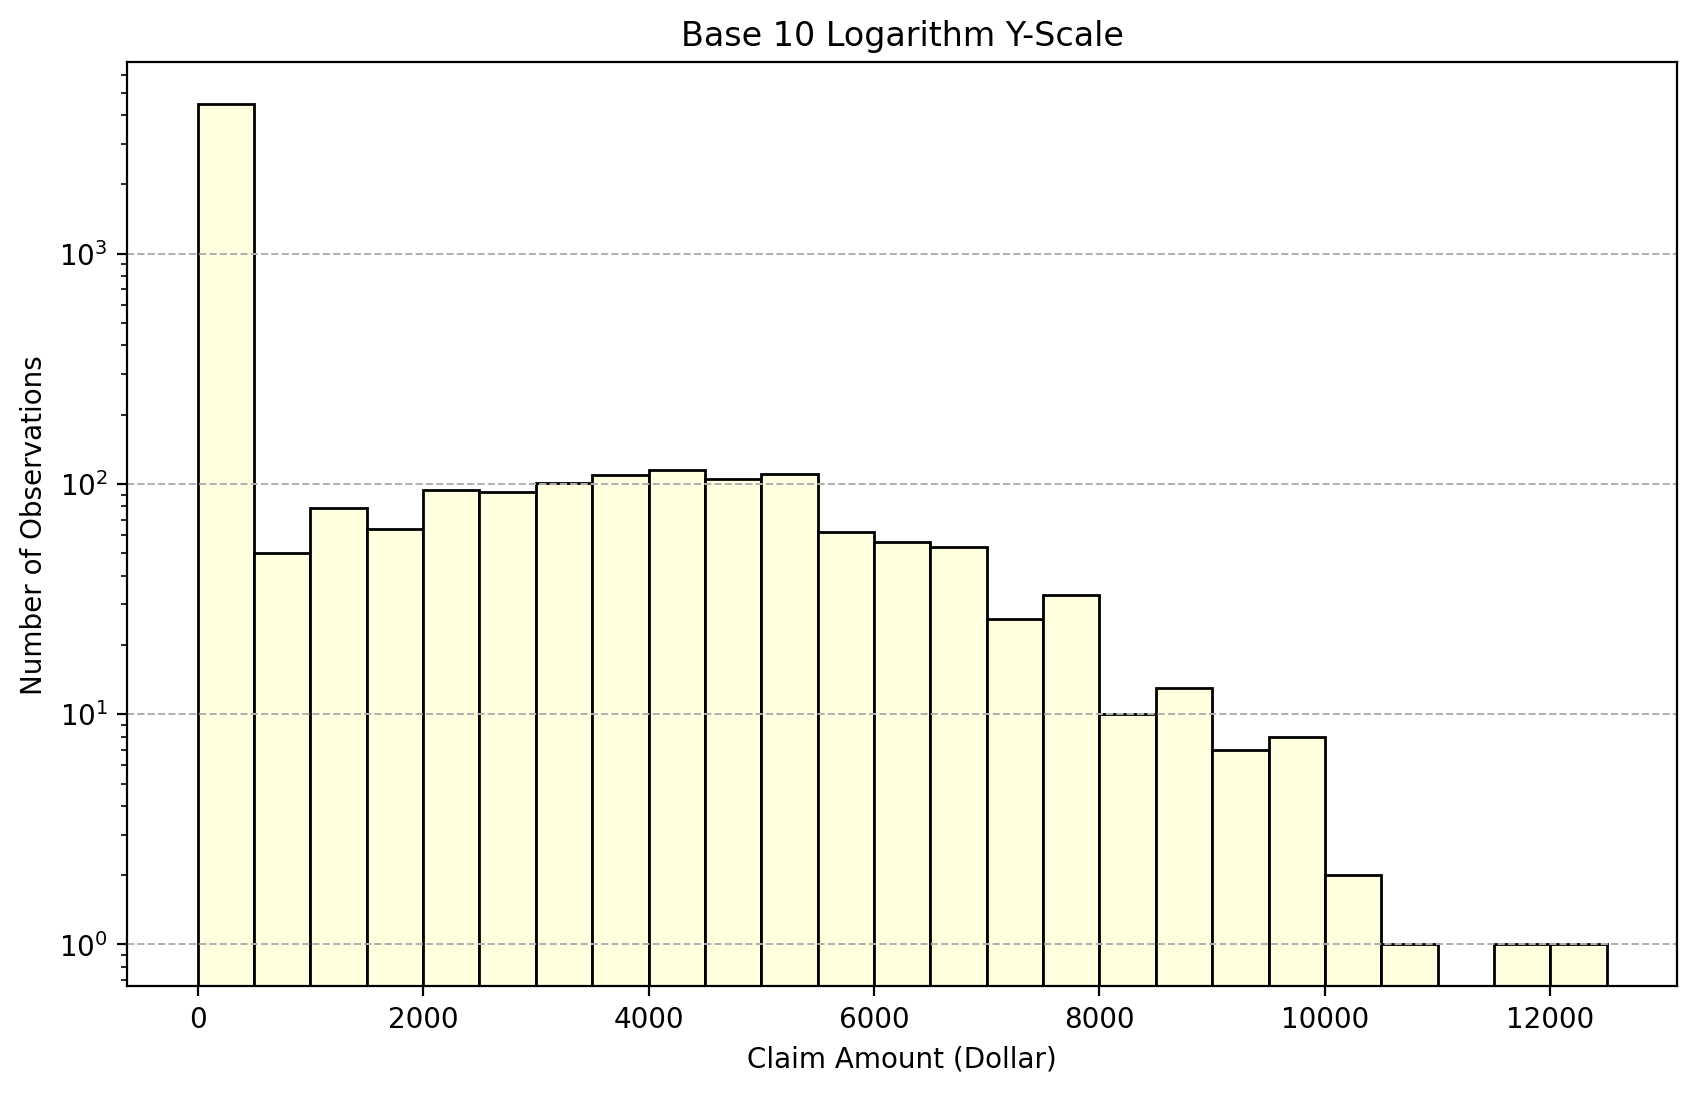

In [6]:
plt.figure(figsize = (10,6), dpi = 200)
plt.hist(y_train, bins = np.arange(0,13000,500), fill = True, color = 
'lightyellow', edgecolor = 'black')
plt.title('Base 10 Logarithm Y-Scale')
plt.xlabel('Claim Amount (Dollar)')
plt.ylabel('Number of Observations')
plt.xticks(np.arange(0,14000,2000))
plt.yscale('log')
plt.grid(axis = 'y', linewidth = 0.7, linestyle = 'dashed')
plt.show()


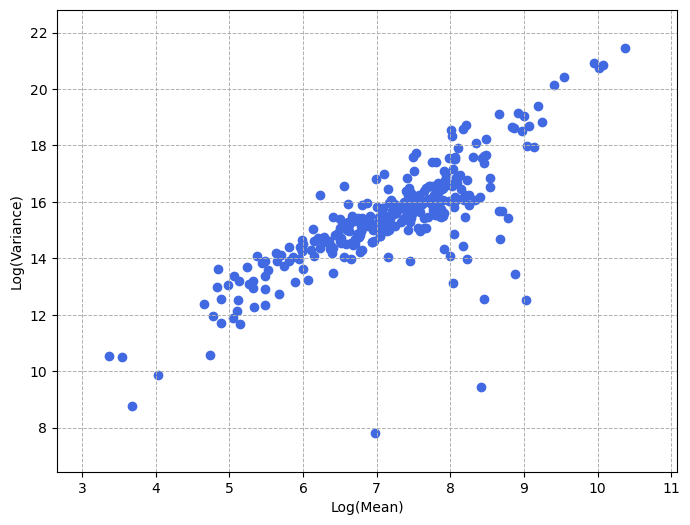

In [7]:
# Estimate the Tweedie's P value
xtab = pd.pivot_table(train_data, values = yName, index = catName,
                          columns = None, aggfunc = ['count', 'mean', 'var'])
cell_stats = xtab[['mean','var']].reset_index().droplevel(1, axis = 1)
ln_Mean = np.where(cell_stats['mean'] > 1e-16, np.log(cell_stats['mean']), 
np.NaN)
ln_Variance = np.where(cell_stats['var'] > 1e-16, np.log(cell_stats['var']), 
np.NaN)
use_cell = np.logical_not(np.logical_or(np.isnan(ln_Mean), 
np.isnan(ln_Variance)))
X_train = ln_Mean[use_cell]
y_train = ln_Variance[use_cell]
# Scatterplot of lnVariance vs lnMean
plt.figure(figsize = (8,6), dpi = 100)
plt.scatter(X_train, y_train, c = 'royalblue')
plt.xlabel('Log(Mean)')
plt.ylabel('Log(Variance)')
plt.margins(0.1)
plt.grid(axis = 'both', linewidth = 0.7, linestyle = 'dashed')
plt.show()


In [8]:
X_train = pd.DataFrame(X_train, columns = ['ln_Mean'])
X_train.insert(0, 'Intercept', 1.0)
y_train = pd.Series(y_train, name = 'ln_Variance')
result_list = Regression.LinearRegression(X_train, y_train)

In [9]:
tweediePower = result_list[0][1]
tweediePhi = np.exp(result_list[0][0])

In [40]:
print(f"Power parameter 𝑝 : {tweediePower}")
print(f"Scale parameter phi : {tweediePhi}")

Power parameter 𝑝 : 1.2840608802234919
Scale parameter phi : 495.39032035257253


In [12]:
# Begin Forward Selection
# The Deviance significance is the sixth element in each row of the test result
def takeDevSig(s):
    return s[7]
nPredictor = len(catName) + len(intName)
stepSummary = []
# Intercept only model
X0_train = train_data[[]]
X0_train.insert(0, 'Intercept', 1.0)
y_train = train_data[yName]
result_list = Regression.TweedieRegression (X0_train, y_train, o_train, tweedieP = 
tweediePower)
qllk0 = result_list[3]
df0 = len(result_list[4])
phi0 = result_list[7]
stepSummary.append([0, 'Intercept', ' ', df0, qllk0, phi0, np.NaN, np.NaN, 
np.NaN])
cName = catName.copy()
iName = intName.copy()
entryThreshold = 0.05
for step in range(nPredictor):
    enterName = ''
    stepDetail = []
    # Enter the next predictor
    for X_name in cName:
        X_train = pd.get_dummies(train_data[[X_name]].astype('category'))
        if (X0_train is not None):
            X_train = X0_train.join(X_train)
        result_list = Regression.TweedieRegression (X_train, y_train, o_train, tweedieP = tweediePower)
        qllk1 = result_list[3]
        df1 = len(result_list[4])
        phi1 = result_list[7]
        devChiSq = 2.0 * (qllk1 - qllk0) / phi0
        devDF = df1 - df0
        devPValue = chi2.sf(devChiSq, devDF)
        stepDetail.append([X_name, 'categorical', df1, qllk1, phi1, devChiSq, devDF, devPValue])
    for X_name in iName:
        X_train = train_data[[X_name]]
        if (X0_train is not None):
            X_train = X0_train.join(X_train)
        result_list = Regression.TweedieRegression (X_train, y_train, o_train, tweedieP = tweediePower)
        qllk1 = result_list[3]
        df1 = len(result_list[4])
        phi1 = result_list[7]
        devChiSq = 2.0 * (qllk1 - qllk0) / phi0
        devDF = df1 - df0
        devPValue = chi2.sf(devChiSq, devDF)
        stepDetail.append([X_name, 'interval', df1, qllk1, phi1, devChiSq, devDF, devPValue])
    # Find a predictor to add, if any
    stepDetail.sort(key = takeDevSig, reverse = False)
    minSig = takeDevSig(stepDetail[0])
    if (minSig <= entryThreshold):
        add_var = stepDetail[0][0]
        add_type = stepDetail[0][1]
        df0 = stepDetail[0][2]
        qllk0 = stepDetail[0][3]
        phi0 = stepDetail[0][4]
        stepSummary.append([step+1] + stepDetail[0])
        if (add_type == 'categorical'):
            X0_train = X0_train.join(pd.get_dummies(train_data[[add_var]].astype('category')))
            cName.remove(add_var)
        else:
            X0_train = X0_train.join(train_data[[add_var]])
            iName.remove(add_var)
    else:
        break
# End of forward selection
stepSummary_df = pd.DataFrame(stepSummary, columns = ['Step','Predictor','Type','N Non-Aliased Parameters',
                                                          'Quasi Log-Likelihood', 'Phi', 'Deviance ChiSquare',
                                                          'Deviance DF', 'Deviance Sig.'])
# Retrain the final model
result_list = Regression.TweedieRegression (X0_train, y_train, o_train, tweedieP = 
tweediePower)
y_pred_B = result_list[6]

b) (10 points). We will use the Forward Selection method to enter predictors into our model. Our
entry threshold is 0.05. Please provide a summary report of the Forward Selection in a table. The
report should include (1) the Step Number, (2) the Predictor Entered, (3) the Model Degree of
Freedom (i.e., the number of non-aliased parameters), (4) the Quasi-Loglikelihood value, (5) the
Deviance Chi-squares statistic between the current and the previous models, (6) the corresponding
Deviance Degree of Freedom, and (7) the corresponding Chi-square significance.

In [13]:
stepSummary_df[['Step','Predictor', 'N Non-Aliased Parameters',
                                                          'Quasi Log-Likelihood', 'Deviance ChiSquare',
                                                          'Deviance DF', 'Deviance Sig.']]

,Step,Predictor,N Non-Aliased Parameters,Quasi Log-Likelihood,Deviance ChiSquare,Deviance DF,Deviance Sig.
0,0,Intercept,1,-2.217255e+06,NaN,NaN,NaN
1,1,URBANICITY,2,-2.118974e+06,506.553405,1.0,3.565332e-112
2,2,EDUCATION,6,-2.057057e+06,333.869471,4.0,5.324835e-71
3,3,CAR_TYPE,11,-1.999000e+06,322.253774,5.0,1.639210e-67
4,4,PARENT1,12,-1.953492e+06,259.708324,1.0,1.986528e-58
5,5,MVR_PTS,13,-1.918088e+06,206.716848,1.0,7.147970e-47
6,6,TRAVTIME,14,-1.902663e+06,91.709156,1.0,1.003993e-21
7,7,CAR_USE,15,-1.888045e+06,87.600934,1.0,8.008682e-21
8,8,REVOKED,16,-1.873858e+06,85.661243,1.0,2.135578e-20
9,9,KIDSDRIV,17,-1.860341e+06,82.221123,1.0,1.216825e-19


c) (10 points). We will calculate the Root Mean Squared Error, the Relative Error, the Pearson
correlation, and the Distance correlation between the observed and the predicted claim amounts of
your final model. Please comment on their values.

In [14]:
# Simple Residual
y_simple_residual = y_train - y_pred_B
# Mean Absolute Proportion Error
ape = np.abs(y_simple_residual) / y_train
mape = np.mean(ape)

# Root Mean Squared Error
mse = np.mean(np.power(y_simple_residual, 2))
rmse = np.sqrt(mse)
print("RMSE :", rmse)

# Relative Error
relerr = mse / np.var(y_train, ddof = 0)
print("Relative Error :", relerr)

# R-Squared
pearson_corr = Regression.PearsonCorrelation (y_train, y_pred_B)
spearman_corr = Regression.SpearmanCorrelation (y_train, y_pred_B)
kendall_tau = Regression.KendallTaub (y_train, y_pred_B)
distance_corr = Regression.DistanceCorrelation (y_train, y_pred_B)

print("Pearson Correlation :", pearson_corr)
print("Distance Correlation :", distance_corr)

RMSE : 4116.064009419275
Relative Error : 1.0078985075249884
Pearson Correlation : 0.18768098705727354
Distance Correlation : 0.27019055675583464


d) (10 points). Please show a table of the complete set of parameters of your final model (including the
aliased parameters). Besides the parameter estimates, please also include the standard errors, the
95% asymptotic confidence intervals, and the exponentiated parameter estimates. Conventionally,
aliased parameters have zero standard errors and confidence intervals. Please also provide us with
the final estimate of the Tweedie distribution’s scale parameter 𝜙.


In [15]:
result_list[0]

,Estimate,Standard Error,Lower 95% CI,Upper 95% CI,Exponentiated
Intercept,8.004594,7.086575e-03,7.990705,8.018484,2994.685416
URBANICITY_Highly Rural/ Rural,-1.668163,2.775794e-03,-1.673603,-1.662722,0.188593
URBANICITY_Highly Urban/ Urban,0.000000,-0.000000e+00,0.000000,0.000000,1.000000
EDUCATION_Bachelors,-0.140701,3.521999e-03,-0.147604,-0.133798,0.868749
EDUCATION_Below High Sc,0.201588,4.333039e-03,0.193096,0.210081,1.223344
EDUCATION_High School,0.096632,3.994529e-03,0.088803,0.104462,1.101455
EDUCATION_Masters,-0.138740,3.440745e-03,-0.145484,-0.131997,0.870454
EDUCATION_PhD,0.000000,-0.000000e+00,0.000000,0.000000,1.000000
CAR_TYPE_Minivan,-0.750292,3.064477e-03,-0.756298,-0.744286,0.472229
CAR_TYPE_Panel Truck,0.017504,3.236289e-03,0.011161,0.023847,1.017659


In [16]:
stepSummary_df.tail(1)['Phi'].values[0]

319.3817800403747

e) (10 points). Please generate a Two-way Lift chart for comparing your final model with the Intercept only model. Based on the chart, what will you conclude about your final model?

In [17]:
# Build a model with only the Intercept term
X_train = train_data[[yName]]
X_train.insert(0, 'Intercept', 1.0)
X_train = X_train.drop(columns = yName)

result = Regression.TweedieRegression (X_train, y_train, o_train, tweedieP = tweediePower)

y_pred_A = result[6]

y_pred_A.name = 'Model A'
y_pred_B.name = 'Model B'

In [18]:
train_data.shape

(5715, 22)

In [19]:
# Normalize the model prediction
prediction = claim_history[[yName, eName]].join(y_pred_A).join(y_pred_B).dropna()
column_sums = np.sum(prediction[['EXPOSURE', 'CLM_AMT','Model A','Model B']], axis = 0)
adjP_CLM_AMT_A = prediction['Model A'] * (column_sums['CLM_AMT'] / column_sums['Model A'])
adjP_CLM_AMT_B = prediction['Model B'] * (column_sums['CLM_AMT'] / column_sums['Model B'])
print('Observed Sum = ', column_sums['CLM_AMT'])
print('Sum of Adjusted Model A = ', np.sum(adjP_CLM_AMT_A))
print('Sum of Adjusted Model B = ', np.sum(adjP_CLM_AMT_B))


Observed Sum =  8669029.0
Sum of Adjusted Model A =  8669029.0
Sum of Adjusted Model B =  8669029.0


In [20]:
prediction = prediction.join(pd.DataFrame({'AdjModel A': adjP_CLM_AMT_A, 'AdjModel B': adjP_CLM_AMT_B}))
prediction['impact'] = adjP_CLM_AMT_B / adjP_CLM_AMT_A

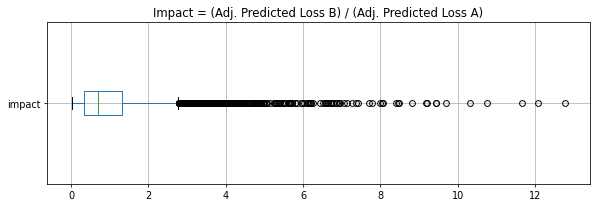

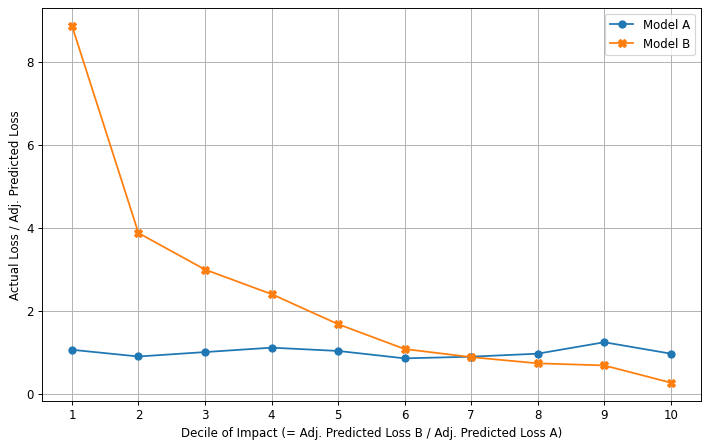

In [42]:
plt.figure(figsize = (10,3), dpi = 70)
prediction.boxplot(column = ['impact'], vert = False)
plt.title('Impact = (Adj. Predicted Loss B) / (Adj. Predicted Loss A)') 
plt.show()
prediction.sort_values(by = 'impact', axis = 0, ascending = True, inplace = True)
prediction['Cumulative Exposure'] = prediction['EXPOSURE'].cumsum()
cumulative_exposure_cutoff = np.arange(0.1, 1.1, 0.1) * column_sums['EXPOSURE']
decile = np.zeros_like(prediction['Cumulative Exposure'], dtype = int)
for i in range(10):
    decile = decile + np.where(prediction['Cumulative Exposure'] > cumulative_exposure_cutoff[i], 1, 0)

prediction['decile'] = decile + 1
xtab = pd.pivot_table(prediction, index = 'decile', columns = None,
                          values = ['EXPOSURE','CLM_AMT','AdjModel A', 'AdjModel B'],
                          aggfunc = ['sum'])
loss_ratio_A = xtab['sum','CLM_AMT'] / xtab['sum','AdjModel A']
loss_ratio_B = xtab['sum','CLM_AMT'] / xtab['sum','AdjModel B']
MAE_A = np.mean(np.abs((loss_ratio_A - 1.0)))
MAE_B = np.mean(np.abs((loss_ratio_B - 1.0)))
 
plt.figure(figsize = (10,6), dpi = 85)
plt.plot(xtab.index, loss_ratio_A, marker = 'o', label = 'Model A')
plt.plot(xtab.index, loss_ratio_B, marker = 'X', label = 'Model B')
plt.xlabel('Decile of Impact (= Adj. Predicted Loss B / Adj. Predicted Loss A)')
plt.ylabel('Actual Loss / Adj. Predicted Loss')
plt.xticks(range(1,11))
plt.grid()
plt.legend()
plt.show()


### Question 2

In [24]:
myeloma = pd.read_csv("myeloma.csv")
myeloma.head()

,Time,VStatus,LogBUN,HGB,Platelet,Age,LogWBC,Frac,LogPBM,Protein,SCalc
0,1.25,1,2.2175,9.4,1,67,3.6628,1,1.9542,12,10
1,1.25,1,1.9395,12.0,1,38,3.9868,1,1.9542,20,18
2,2.00,1,1.5185,9.8,1,81,3.8751,1,2.0000,2,15
3,2.00,1,1.7482,11.3,0,75,3.8062,1,1.2553,0,12
4,2.00,1,1.3010,5.1,0,57,3.7243,1,2.0000,3,9


In [25]:
myeloma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Time      65 non-null     float64
 1   VStatus   65 non-null     int64  
 2   LogBUN    65 non-null     float64
 3   HGB       65 non-null     float64
 4   Platelet  65 non-null     int64  
 5   Age       65 non-null     int64  
 6   LogWBC    65 non-null     float64
 7   Frac      65 non-null     int64  
 8   LogPBM    65 non-null     float64
 9   Protein   65 non-null     int64  
 10  SCalc     65 non-null     int64  
dtypes: float64(5), int64(6)
memory usage: 5.7 KB


In [26]:
myeloma.VStatus.value_counts()

1    48
0    17
Name: VStatus, dtype: int64

b) (10 points). We will use the Kaplan-Meier Product Limit Estimator to create the life table. Please
provide us with the life table.

In [31]:
# Calculate the Kaplan-Meier Product Limit Estimator for the Survival Function
xtab = pd.crosstab(index = myeloma['Time'], columns = myeloma['VStatus'])
lifeTable = pd.DataFrame({'Survival Time': 0, 'Number Left': nUnit, 'Number of Events': 0, 'Number Censored': 0}, index = [0])
lifeTable = pd.concat([lifeTable, pd.DataFrame({'Survival Time': 
xtab.index, 'Number of Events': xtab[1].to_numpy(),
                                                        'Number Censored': 
xtab[0].to_numpy()})],
                          axis = 0, ignore_index = True)
lifeTable[['Number at Risk']] = nUnit
nTime = lifeTable.shape[0]
probSurvival = 1.0
hazardFunction = 0.0
seProbSurvival = 0.0
lifeTable.at[0,'Prob Survival'] = probSurvival
lifeTable.at[0,'Prob Failure'] = 1.0 - probSurvival
lifeTable.at[0,'Cumulative Hazard'] = hazardFunction
for i in np.arange(1,nTime):
    nDeath = lifeTable.at[i,'Number of Events']
    nAtRisk = lifeTable.at[i-1,'Number Left'] - lifeTable.at[i-1,'Number Censored']
    nLeft = nAtRisk - nDeath
    probSurvival = probSurvival * (nLeft / nAtRisk)
    seProbSurvival = seProbSurvival + nDeath / nAtRisk / nLeft
    hazardFunction = hazardFunction + (nDeath / nAtRisk)
    lifeTable.at[i, 'SE Prob Survival'] = seProbSurvival
    lifeTable.at[i,'Number Left'] = nLeft
    lifeTable.at[i,'Number at Risk'] = nAtRisk
    lifeTable.at[i,'Prob Survival'] = probSurvival
    lifeTable.at[i,'Prob Failure'] = 1.0 - probSurvival
    lifeTable.at[i,'Cumulative Hazard'] = hazardFunction
lifeTable['SE Prob Survival'] = lifeTable['Prob Survival'] * np.sqrt(lifeTable['SE Prob Survival'])
CIHalfWidth = norm.ppf(0.975) * lifeTable['SE Prob Survival']
u = lifeTable['Prob Survival'] - CIHalfWidth
lifeTable['Lower CI Prob Survival'] = np.where(u < 0.0, 0.0, u)
u = lifeTable['Prob Survival'] + CIHalfWidth
lifeTable['Upper CI Prob Survival'] = np.where(u > 1.0, 1.0, u)

In [32]:
lifeTable

,Survival Time,Number Left,Number of Events,Number Censored,Number at Risk,Prob Survival,Prob Failure,Cumulative Hazard,SE Prob Survival,Lower CI Prob Survival,Upper CI Prob Survival
0,0.00,65.0,0,0,65,1.000000,0.000000,0.000000,NaN,NaN,NaN
1,1.25,63.0,2,0,65,0.969231,0.030769,0.030769,0.021420,0.927249,1.000000
2,2.00,60.0,3,0,63,0.923077,0.076923,0.078388,0.033051,0.858297,0.987857
3,3.00,59.0,1,0,60,0.907692,0.092308,0.095055,0.035903,0.837324,0.978061
4,4.00,59.0,0,2,59,0.907692,0.092308,0.095055,0.035903,0.837324,0.978061
5,5.00,55.0,2,0,57,0.875843,0.124157,0.130143,0.041104,0.795281,0.956406
6,6.00,51.0,4,0,55,0.812146,0.187854,0.202870,0.048921,0.716262,0.908030
7,7.00,48.0,3,2,51,0.764372,0.235628,0.261693,0.053254,0.659996,0.868749
8,8.00,46.0,0,1,46,0.764372,0.235628,0.261693,0.053254,0.659996,0.868749
9,9.00,44.0,1,0,45,0.747386,0.252614,0.283916,0.054713,0.640151,0.854622


a) (10 points). How many risk sets are there?

In [37]:
lifeTable['Number at Risk'].nunique()

38

c) (10 points). According to the life table, what is the Probability of Survival and the Cumulative Hazard
at a survival time of 18 months? What do these two values mean to a layperson?

In [33]:
lifeTable.loc[lifeTable['Survival Time'] == 18.00][['Survival Time', 'Prob Survival', 'Cumulative Hazard']]

,Survival Time,Prob Survival,Cumulative Hazard
17,18.0,0.509496,0.653547


d) (10 points). Please generate the Survival Function graph using the Kaplan-Meier Product Limit
Estimator life table. Since we measure the Time variable in the number of months, we will specify
the x-axis ticks from 0 with an increment of 12. Besides plotting the Survival Function versus Time,
you must also add the 95% Confidence Band. You might use the matplotlib fill_between()
function to generate the Confidence Band as a band around the Survival Function. To receive the
full credits, you must label the chart elements properly

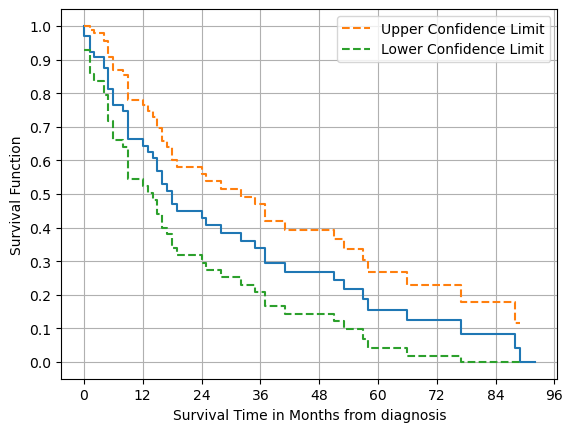

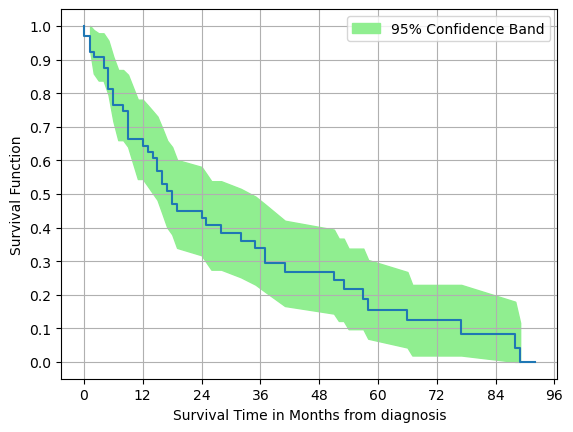

In [34]:
plt.figure(dpi = 100)
plt.plot(lifeTable['Survival Time'], lifeTable['Prob Survival'], drawstyle = 
'steps')
plt.plot(lifeTable['Survival Time'], lifeTable['Upper CI Prob Survival'], drawstyle
= 'steps',
         linestyle = 'dashed', label = 'Upper Confidence Limit')
plt.plot(lifeTable['Survival Time'], lifeTable['Lower CI Prob Survival'], drawstyle
= 'steps',
         linestyle = 'dashed', label = 'Lower Confidence Limit')
plt.xlabel('Survival Time in Months from diagnosis')
plt.ylabel('Survival Function')
plt.xticks(np.arange(0,100,12))
plt.yticks(np.arange(0.0,1.1,0.1))
plt.grid(axis = 'both')
plt.legend()
plt.show()
# Plot the Survival Function with a Confidence Band
plt.plot(lifeTable['Survival Time'], lifeTable['Prob Survival'], drawstyle = 
'steps')
plt.fill_between(lifeTable['Survival Time'], lifeTable['Lower CI Prob Survival'], 
lifeTable['Upper CI Prob Survival'],
                 color = 'lightgreen', label = '95% Confidence Band')
plt.xlabel('Survival Time in Months from diagnosis')
plt.ylabel('Survival Function')
plt.xticks(np.arange(0,100,12))
plt.yticks(np.arange(0.0,1.1,0.1))
plt.grid(axis = 'both')
plt.legend()
plt.show()


e) (10 points). Use Linear Interpolation to determine the Median Survival Time (in number of months)
from the Kaplan-Meier Product Limit Estimator life table. Please round your answer up to the
tenths place.

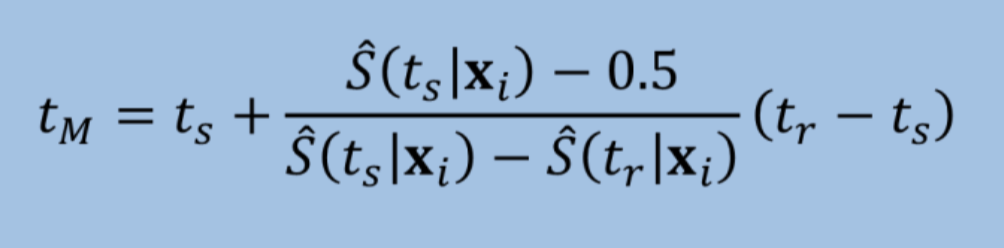

In [43]:
time_months = lifeTable['Survival Time'].values
survival_probs = lifeTable['Prob Survival'].values


ind_r = np.argmax(survival_probs < 0.5)
ind_s = ind_r-1

ts = time_months[ind_s]
tr = time_months[ind_r]

ps = survival_probs[ind_s]
pr = survival_probs[ind_r]

median_time = ts + ((ps - 0.5) / (ps - pr)) * (tr - ts)

# round median_time to the tenths place
median_time_rounded = round(median_time, 1)

print(f"Median Survival Time (in number of months) is {median_time_rounded} months.")


Median Survival Time (in number of months) is 18.2 months.
